In [1]:
import imports as im
import functions as fn
%matplotlib inline

In [23]:
# Set path to directory with folders train and test
df = im.pd.read_csv('../data/data/train.csv')
# path_train = '../data/data/train_wav/'
path_train = '../datasets/train_wav/'
path_train_noised = '../datasets/train_wavs_noised_002/'

Create datasets

- train : 80%
- val : 10%
- test : 10%

In [24]:
# takes roughly 10-15 minutes
x_data_hc, y_data_hc = fn.create_HC_dataset_wavs(df, path_train, Noised=False)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/librosa/feature/spectral.py:2157: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


10.0 % completed
20.0 % completed
30.0 % completed
40.0 % completed
50.0 % completed
60.0 % completed
70.0 % completed
80.0 % completed
90.0 % completed
100.0 % completed


In [ ]:
# create Complexity-Entropy datasets from wav-file with ordpy (work worse and longer, than the previous method)

# train_index = int(len(df["clip_name"]) * 0.9)
# val_index = train_index + int(len(df["clip_name"]) * 0.05)
# x_train_hc_ord, y_train_hc_ord, x_val_hc_ord, y_val_hc_ord, x_test_hc_ord, y_test_hc_ord = fn.create_hc_dataset_ordpy(df, path_train, train_index, val_index)

In [25]:
x_train_val, x_test_hc, y_train_val, y_test_hc = im.train_test_split(x_data_hc, y_data_hc, test_size=0.1, random_state=42, shuffle=True, stratify=y_data_hc)

In [26]:
x_train_hc, x_val_hc, y_train_hc, y_val_hc = im.train_test_split(x_train_val, y_train_val, test_size=0.1, random_state=42, shuffle=True, stratify=y_train_val)

In [27]:
train_data_hc = im.tf.data.Dataset.from_tensor_slices((x_train_hc, y_train_hc))
val_data_hc = im.tf.data.Dataset.from_tensor_slices((x_val_hc, y_val_hc))
test_data_hc = im.tf.data.Dataset.from_tensor_slices((x_test_hc, y_test_hc))

batch_size = 64

train_data_hc = train_data_hc.batch(batch_size)
val_data_hc = val_data_hc.batch(batch_size)
test_data_hc = test_data_hc.batch(batch_size)

## Inception Time

In [32]:
num_classes = 2

def make_model(input_shape):
    input_layer = im.keras.layers.Input(input_shape)

    conv1 = im.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same")(input_layer)
    conv1 = im.keras.layers.BatchNormalization()(conv1)
    conv1 = im.keras.layers.ReLU()(conv1)

    drop1 = im.keras.layers.Dropout(0.2)(conv1)

    conv2 = im.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same")(drop1)
    conv2 = im.keras.layers.BatchNormalization()(conv2)
    conv2 = im.keras.layers.ReLU()(conv2)

    drop2 = im.keras.layers.Dropout(0.2)(conv2)

    conv3 = im.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same")(conv2)
    conv3 = im.keras.layers.BatchNormalization()(conv3)
    conv3 = im.keras.layers.ReLU()(conv3)

    drop3 = im.keras.layers.Dropout(0.2)(conv3)

    gap = im.keras.layers.GlobalAveragePooling1D()(drop3)

    output_layer = im.keras.layers.Dense(num_classes, activation="softmax")(gap)

    return im.keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape=x_train_hc.shape[1:])
# im.keras.utils.plot_model(model, show_shapes=True)

In [33]:
epochs = 500
weights_inception = "../weights_inception/InceptionTime.h5"

callbacks = [
    im.keras.callbacks.ModelCheckpoint(
        weights_inception, save_best_only=True, monitor="val_loss"
    ),
    im.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, mode='min', min_lr=0
    ),
    im.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

In [34]:
HistoryInception = model.fit(
    train_data_hc,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_data_hc,
    verbose=1,
)

Epoch 1/500
380/380 [==============================] - 2s 4ms/step - loss: 0.4759 - sparse_categorical_accuracy: 0.7548 - val_loss: 0.4520 - val_sparse_categorical_accuracy: 0.7737 - lr: 0.0010
Epoch 2/500
380/380 [==============================] - 2s 4ms/step - loss: 0.4383 - sparse_categorical_accuracy: 0.7653 - val_loss: 0.4289 - val_sparse_categorical_accuracy: 0.7885 - lr: 0.0010
Epoch 3/500
380/380 [==============================] - 2s 4ms/step - loss: 0.4281 - sparse_categorical_accuracy: 0.7724 - val_loss: 0.4101 - val_sparse_categorical_accuracy: 0.7904 - lr: 0.0010
Epoch 4/500
380/380 [==============================] - 2s 4ms/step - loss: 0.4165 - sparse_categorical_accuracy: 0.7793 - val_loss: 0.5001 - val_sparse_categorical_accuracy: 0.7637 - lr: 0.0010
Epoch 5/500
380/380 [==============================] - 2s 4ms/step - loss: 0.4127 - sparse_categorical_accuracy: 0.7806 - val_loss: 0.3859 - val_sparse_categorical_accuracy: 0.8044 - lr: 0.0010
Epoch 6/500
380/380 [=========

In [35]:
model = im.keras.models.load_model(weights_inception)

test_loss, test_acc = model.evaluate(test_data_hc)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

47/47 [==============================] - 0s 1ms/step - loss: 0.3477 - sparse_categorical_accuracy: 0.8297
Test accuracy 0.8296666741371155
Test loss 0.3477345108985901


In [39]:
metric = "sparse_categorical_accuracy"

LossInception = HistoryInception.history["loss"]
ValLossInception = HistoryInception.history["val_loss"]

AccInception = HistoryInception.history[metric]
ValAccInception = HistoryInception.history["val_" + metric]

EpochsInception = range(1, len(AccInception) + 1)

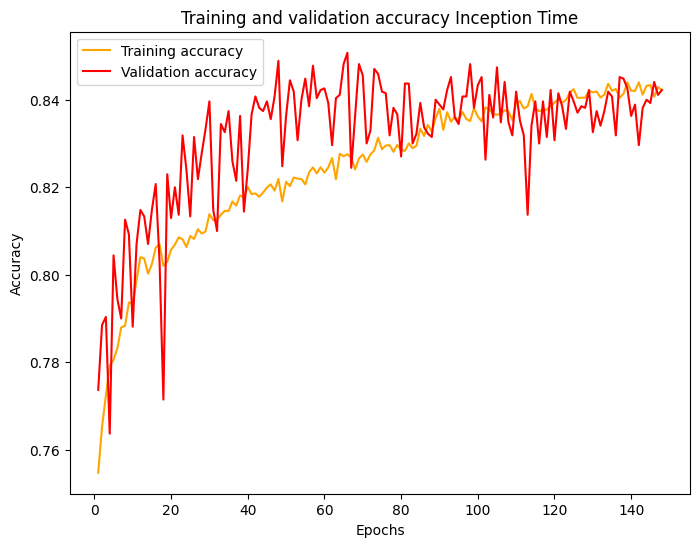

In [37]:
fn.PlotLossAcc(TrainData=AccInception, ValData=ValAccInception, Epochs=EpochsInception,
            TrainLabel='Training accuracy', ValLabel='Validation accuracy',
            yLabel='Accuracy', title='Training and validation accuracy Inception Time',
            ColTrain='orange', ColVal='red', filename="../images/acc_inception.pdf")

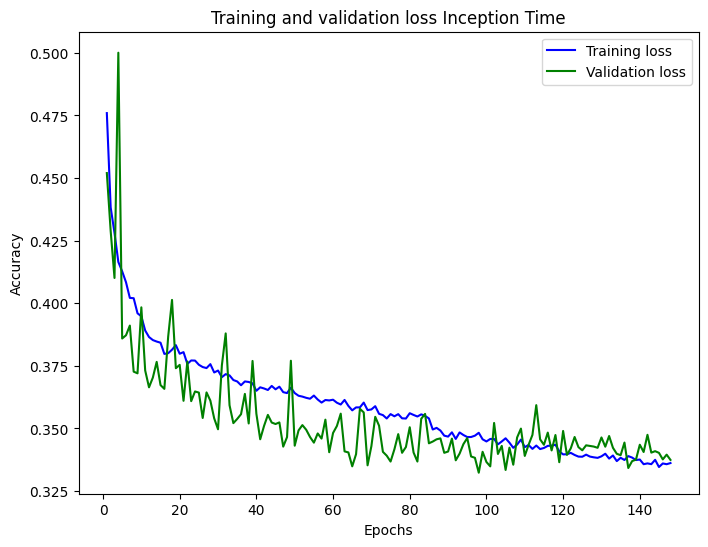

In [40]:
fn.PlotLossAcc(TrainData=LossInception, ValData=ValLossInception, Epochs=EpochsInception,
            TrainLabel='Training loss', ValLabel='Validation loss',
            yLabel='Accuracy', title='Training and validation loss Inception Time',
            ColTrain='blue', ColVal='green', filename="../images/loss_inception.pdf")